#Задача: Определить, какая часть света отличается от других в статистике заражения COVID-19

Это решение расположено в репозитории https://github.com/crazyelf1971/odb21/

##Описание задачи

https://open-data-battle.geecko.com/issues/covid19_1  
Дана статистика заболеваемости коронавирусом за определенный промежуток в разных странах, записанная в файл covid-19cases.csv. Необходимо:  
- Произвести очистку данных, убрав пустые столбцы и неинформативные строки (строки, выделенные для заметок for Notes)
- Определить статистику случаев заражения в разных частях света (столбец continent) за каждый месяц
- Определить корреляцию каждой части света с другой.
- Вывести название части света, которая меньше всего коррелирует с другими

##Скачивание данных

Если ссылка на соревнование перестанет быть актуальной, можно будет взять файлы из моего репозитория с решениями https://github.com/crazyelf1971/odb21  
При запуске не из Google Colab можно использовать для скачки библиотеку wget и вызовы os.system, либо просто взять готовый csv файл из репозитория и пропустить этот шаг.

In [1]:
import gdown

file_name = gdown.download('https://open-data-battle.geecko.com/dataset/covid19_1.zip',None, False)
!unzip {file_name}
!ls -la *.csv

Downloading...
From: https://open-data-battle.geecko.com/dataset/covid19_1.zip
To: /content/covid19_1.zip
2.27MB [00:01, 1.50MB/s]


Archive:  covid19_1.zip
  inflating: covid-19cases.csv       
-rw-rw-r-- 1 root root 17742723 Aug 11 22:13 covid-19cases.csv


##Загрузка данных

In [2]:
import pandas as pd
import numpy as np

# чтение данных из файла
df = pd.read_csv('covid-19cases.csv', index_col=0)

# посмотрим на данные
df.info(memory_usage='deep')
df.loc[:,df.dtypes=='object'].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105748 entries, 0 to 105747
Data columns (total 45 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   date                             105748 non-null  object 
 1   continent                        52269 non-null   object 
 2   location                         52873 non-null   object 
 3   total_cases                      49259 non-null   float64
 4   new_cases                        51979 non-null   float64
 5   new_cases_smoothed               51185 non-null   float64
 6   total_deaths                     40323 non-null   float64
 7   new_deaths                       51979 non-null   float64
 8   new_deaths_smoothed              51185 non-null   float64
 9   total_cases_per_million          48993 non-null   float64
 10  new_cases_per_million            51915 non-null   float64
 11  new_cases_smoothed_per_million   51120 non-null   float64
 12  to

,date,continent,location,tests_units,iso_code
0,13-03-20,North America,Aruba,NaN,ABW
1,For Notes:,NaN,NaN,NaN,NaN
2,19-03-20,North America,Aruba,NaN,ABW
3,For Notes:,NaN,NaN,NaN,NaN
4,20-03-20,North America,Aruba,NaN,ABW


##Очистка данных

Данные можно и не чистить, потому что после аггрегации строки с `NA` и сами пропадут. Но в ТЗ написано сделать чистку.

In [3]:
# удаление строк "для заметок"
df = df[~df['date'].str.contains('notes', case=False)]

# удаление пустого континента
df = df[~df['continent'].isna()]

##Подготовка данных

- нас интересует только часть данных из таблицы: год, месяц, локация, континент и число случаев
- предположительно, в данных по локациям есть пропуски за какие-то дни, поэтому надёжнее в данном случае не суммировать данные за месяц, а взять максимальное число случаев внутри месяца как итоговую цифру за этот месяц
- для получения данных за месяц по континенту просто суммируем данные по локациям этого континента
- добавляем в таблицу данные по всему миру как сумму данных по всем континентам

In [4]:
# выбор только интересующих нас столбцов
df = df[['continent','location','month','year','total_cases']]

# данные по каждой локации на конец месяца
df_agg = df.groupby(['continent','location','month','year']).agg({'total_cases': np.max}).fillna(0)

# данные по континентам
df_total = df_agg.groupby(['continent','month','year']).agg({'total_cases': np.sum})
df_total = df_total.sort_values(['year','month']).reset_index()

# данные по всему миру
df_world = df_agg.groupby(['month','year']).agg({'total_cases': np.sum}).reset_index()
df_world['continent'] = 'World'

# объединённые данные
df_total = pd.concat([df_total, df_world], ignore_index=True)

##Решение задачи

- создаём сводную таблицу числа случаев по континентам за каждый месяц
- считаем матрицу корреляции континентов (включая мир)
- выводим континент у которого наименьшая корреляция с миром

In [5]:
# сводная таблица для анализа
df_pivot = df_total.pivot(index=['month','year'], columns='continent', values=['total_cases'])

# матрица корреляции
df_corr = df_pivot.corr()

# континент, наименее коррелирующий с миром
min_corr = df_corr[('total_cases','World')].sort_values()
print(f'Наименее коррелирует с остальным миром: {min_corr.index[0][1]} с коэффициентом {min_corr.values[0]:.2f}')

Наименее коррелирует с остальным миром: Europe с коэффициентом 0.97


##Визуализация

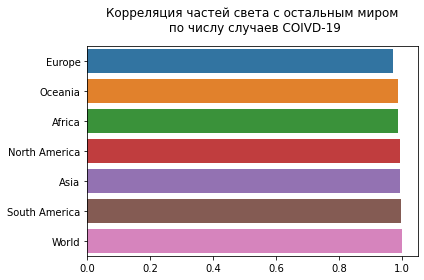

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=('total_cases','World'), y='continent', data=df_corr[('total_cases','World')].sort_values().reset_index());
plt.title('Корреляция частей света с остальным миром\n по числу случаев COIVD-19', pad=15);
plt.xlabel('')
plt.ylabel('')
plt.tight_layout();

Наглядно видно, что Европа наименее всего коррелирует с остальным миром.  
И хотя разница между частями света не очень большая, но Европа всё же заметно выделяется.

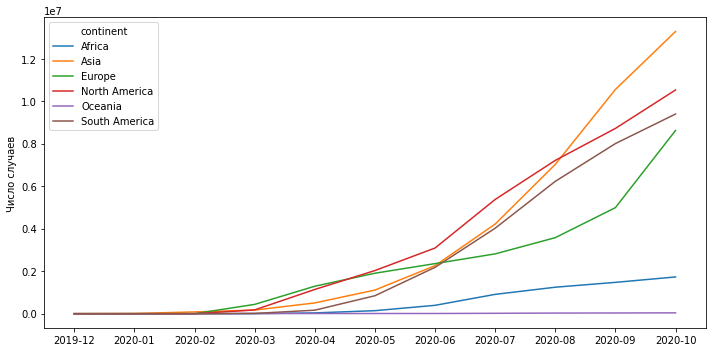

In [7]:
plt.figure(figsize=(10,5))
df_total['year-month'] = df_total.apply(lambda x: f'20{x["year"]:02.0f}-{x["month"]:02.0f}', axis=1)
sns.lineplot(x='year-month', y='total_cases', hue='continent', data=df_total[df_total.continent != 'World'])
plt.xlabel('')
plt.ylabel('Число случаев')
plt.tight_layout()

Видно, что у Европы график роста числа случаев отличается от других континентов: после мая 2020 в Европе рост замедлился, а после сентября 2020 усилился, на других континентах сильных перепадов скорости роста случаев в этих точках не наблюдается.  
График Азии отличается более сильным ростом после июля 2020, но всё же он больше похож на графики остальных континентов, чем график Европы.